<a target="_blank" href="https://colab.research.google.com/github/taobrienlbl/advanced_earth_science_data_analysis/blob/spring_2023_iub/lessons/07_machine_learning_intro/07_workalong01_machine_learning_basics_SOLUTION.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Machine Learning Basics

This workalong walks through some of the basic elements of modern machine learning, including *rectified linear units (reLU)*, *loss functions*, *backpropagation*, and the use of `pytorch`.

## Rectified linear units (reLU)

In the cell below, implement two functions:
 1. `linear(x,w,b)`
 2. `relu(x)` 

as indicated in the functions' docstrings.  (Note, remove the lines with `pass` - this is just a line of code that says to Python "do nothing"...it's necessary because function's can't be empty in Python.)

Test that it works as expected, and keep your tests in the notebook.

In [1]:
""" Define a linear and relu function. """
import numpy as np

def linear(x : np.ndarray, w : float = 1, b : float = 0) -> np.ndarray:
    """ returns w*x + b """
    return w*x + b

def relu(x : np.ndarray) -> np.ndarray:
    """ returns x if x is positive, 0 otherwise"""
    return np.maximum(x, 0)

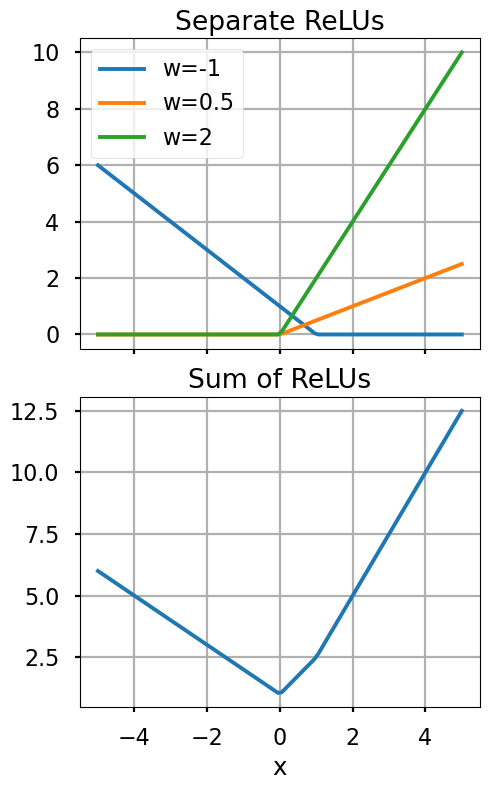

In [2]:
""" Test the relu function. """
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-poster')

# define several slope values
w_vec = [-1, 0.5, 2]
b_vec = [1, 0, 0]

# define a range of x values
x = np.linspace(-5, 5, 100)

# plot the relu for each slope
fig, axs = plt.subplots(2, 1, figsize=(5, 8), sharex = True)

for w,b in zip(w_vec,b_vec):
    axs[0].plot(x, relu(linear(x, w, b)), label=f"w={w}")
axs[0].legend()
axs[0].grid()
axs[0].set_title("Separate ReLUs")

# plot the sum of the relus
z = None
for w, b in zip(w_vec, b_vec):
    if z is None:
        z = relu(linear(x, w, b))
    else:
        z += relu(linear(x, w, b))

axs[1].plot(x, z)
axs[1].set_xlabel("x")
axs[1].grid()
axs[1].set_title("Sum of ReLUs")

plt.tight_layout()
plt.show()


## Fitting a function with reLUs

1. Run the cell below to create a graph of fake, noisy data (variable `noisy_data`).
1. In the cell below that, create a function `relu_sum` that is the sum of two reLUs with a bias (a scalar) added at the end
1. Create a new plot that includes the function output and the noisy data
1. Adjust the `w` and `b` parameters until the function approximates the fake data.
1. Comment in a markdown cell on your observations, what you learned, etc.



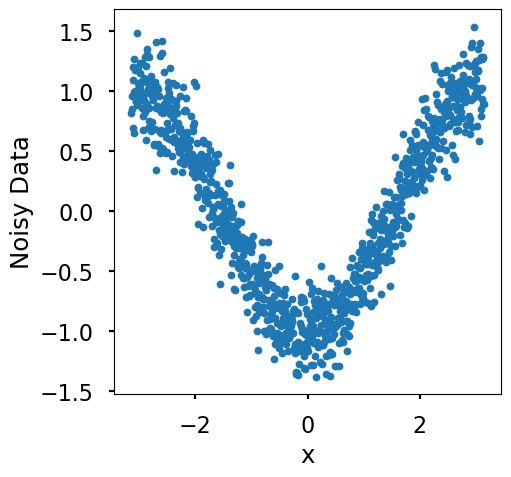

In [3]:
""" Create a fake, noisy dataset. """

# define the x values
x = np.linspace(-np.pi, np.pi, 1000)

# define the y values of the true function
y_true = -np.cos(x)

# add some noise to the true function
np.random.seed(5984)
noisy_data = y_true + np.random.normal(0, 0.2, len(x))

# plot the noisy data
fig, ax = plt.subplots(figsize = (5,5))
ax.plot(x, noisy_data, '.', label="data")
ax.set_xlabel("x")
ax.set_ylabel("Noisy Data")
plt.show()

In [4]:
""" Define a function that is the sum of two relus. """

def relu_sum(x : np.ndarray, w : np.ndarray, b : np.ndarray, bias : float = 0) -> np.ndarray:
    """ returns relu(w[0]*x + b[0]) + relu(w[1]*x + b[1]) + ... + bias with the number of relu terms equal to the length of w and b """
    # check that w and b are the same length
    assert len(w) == len(b), "w and b must be the same length"

    # initialize the output
    z = np.zeros_like(x) + bias

    # add each relu term
    for w_i, b_i in zip(w, b):
        z += relu(linear(x, w_i, b_i))

    return z




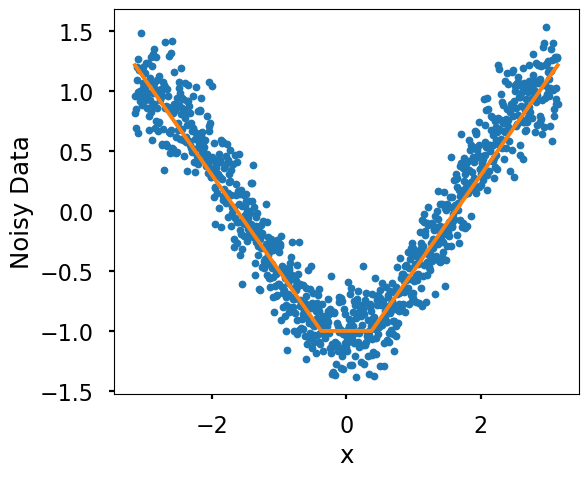

In [5]:
""" Plot the sum of two relus. """
# set the weights, the offsets, and the bias
w = [-0.8,  0.8]
b = [-0.3, -0.3]
bias = -1

# plot the noisy data and fit
fig, ax = plt.subplots(figsize = (6,5))
ax.plot(x, noisy_data, '.', label="data")
ax.plot(x, relu_sum(x, w, b, bias = bias), label="fit")
ax.set_xlabel("x")
ax.set_ylabel("Noisy Data")
plt.show()

## Loss function

Now define a *loss* function $\mathcal{L}$: in this case *mean-squared error (MSE)* for the fit $\hat{\mathbf{z}}$ relative to the data $\mathbf{z}$

$$ \mathcal{L} = \frac{1}{N} \sum\limits_{i=0}^{N-1} (z_i - \hat{z}_i)^2$$

Calculate the loss for your fit to the data above: we'll compare in class.

In [6]:
""" Define a loss function. """

def loss(y_true : np.ndarray, y_pred : np.ndarray) -> float:
    """ returns the mean squared error between y_true and y_pred """
    return np.mean((y_true - y_pred)**2)

# calculate the loss for the fit
z_fit = relu_sum(x, w, b, bias = bias)

print(f"The loss for the fit is {loss(noisy_data, z_fit):.3f}")

The loss for the fit is 0.047


Add the loss to the title of the plot, and vary the parameters further to see if you can minimize the loss.

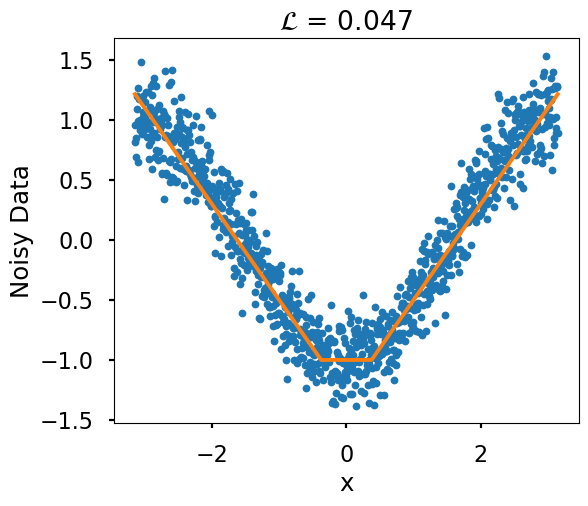

In [7]:
""" Vary parameters, minimizing the loss (include loss in title). """

# set the weights, the offsets, and the bias
w = [-0.8,  0.8]
b = [-0.3, -0.3]
bias = -1

# calculate the loss for the fit
z_fit = relu_sum(x, w, b, bias = bias)

# calculate the loss
mse = loss(noisy_data, z_fit)

# plot the noisy data and fit
fig, ax = plt.subplots(figsize = (6,5))
ax.plot(x, noisy_data, '.', label="data")
ax.plot(x, relu_sum(x, w, b, bias = bias), label="fit")
ax.set_xlabel("x")
ax.set_ylabel("Noisy Data")
ax.set_title("$\mathcal{L}$ = " +  f"{mse:.3f}")
plt.show()

## ReLUs in `pytorch`

Now we'll take advantage of `pytorch` for automating the process of fitting a NN model.

In [8]:
""" Define a neural network with a single hidden layer. """
# import pytorch
import torch
import torch.nn as nn
# set the random seed for reproducibility
torch.manual_seed(5984)

class Net(nn.Module):
    def __init__(self, n_hidden : int = 2):
        # initialize the parent class
        super().__init__()

        # note the use of 1 in the following: this is the dimensionality of the input (1D)
        # the extra linear layer serves to sum the relu terms and add a bias
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(1, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, 1)
        )

    def forward(self, x):
        """ Define the forward pass; how the network should act like a function"""
        out = self.linear_relu_stack(x)
        return out

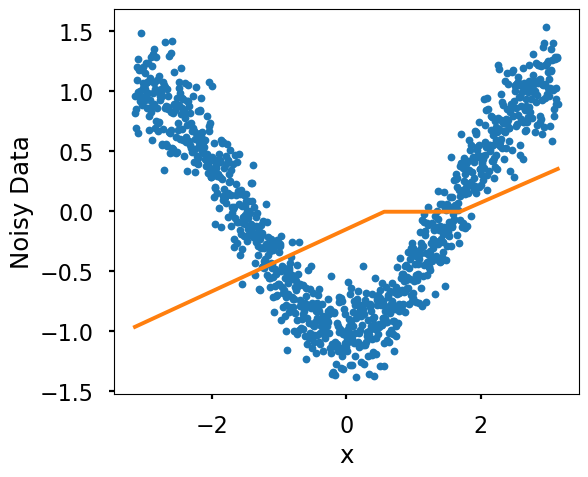

In [9]:
""" Show the initial model prediction/fit (it's bad)"""
# convert the x values and y values to pytorch tensors
xt = torch.from_numpy(x).unsqueeze(1).to(torch.float32)
yt = torch.from_numpy(noisy_data).unsqueeze(1).to(torch.float32)

# create the 2 relu model
model_2 = Net(n_hidden = 2)

# calculate the prdiction
pred = model_2(xt)

# plot the noisy data and fit
fig, ax = plt.subplots(figsize = (6,5))
ax.plot(x, noisy_data, '.', label="data")
ax.plot(x, pred.detach().numpy(), label="fit")
ax.set_xlabel("x")
ax.set_ylabel("Noisy Data")
plt.show()

### Training the model - the simple, but not-so-great way

We'll use a simple for loop to train the model on all the data.  This is bad because we don't split the dataset into train, test, and validation sets; this can make our efforts prone to overfitting.

But for simplicity, we'll forge forward with this (inadvisable) approach.

In [10]:
""" Train the model the bad way. """

# set hyperparameters
learning_rate = 0.01
training_steps = 1000

# define the model
torch.manual_seed(5984)
model_2 = Net(n_hidden = 2)

# define the loss function
loss_fn = nn.MSELoss()

# define the optimizer
optim = torch.optim.Adam(model_2.parameters(), lr = learning_rate)

for n in range(training_steps):
    # calculate the prediction
    pred = model_2(xt)

    # calculate the loss
    loss = loss_fn(pred, yt)

    # zero the gradients
    optim.zero_grad()

    # calculate the gradients of the parameters wrt the loss
    loss.backward()

    # update the parameters
    optim.step()

    # print the loss every 100 steps
    if n % 100 == 0:
        print(f"Step {n}: {loss.item():.3f}")


Step 0: 0.837
Step 100: 0.223
Step 200: 0.046
Step 300: 0.045
Step 400: 0.045
Step 500: 0.045
Step 600: 0.045
Step 700: 0.045
Step 800: 0.045
Step 900: 0.045


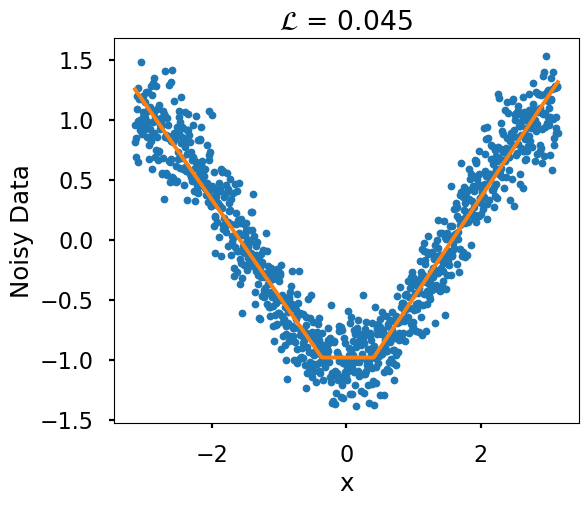

In [11]:
""" Plot the trained model. """
# calcuate the prediction
pred = model_2(xt)

# calculate the loss
loss = loss_fn(pred, yt)

# plot the noisy data and fit
fig, ax = plt.subplots(figsize = (6,5))
ax.plot(x, noisy_data, '.', label="data")
ax.plot(x, pred.detach().numpy(), label="fit")
ax.set_xlabel("x")
ax.set_ylabel("Noisy Data")
ax.set_title("$\mathcal{L}$ = " +  f"{loss.item():.3f}")
plt.show()

### Training the model - the better, but more complicated way

We'll follow standard practice here to split the data into test, train and validation sets.  We'll also use pytorch's data loader to do training in batches, and we'll put our training loop into a function.  This will allow us to train in *epochs* (passes through the entire dataset).

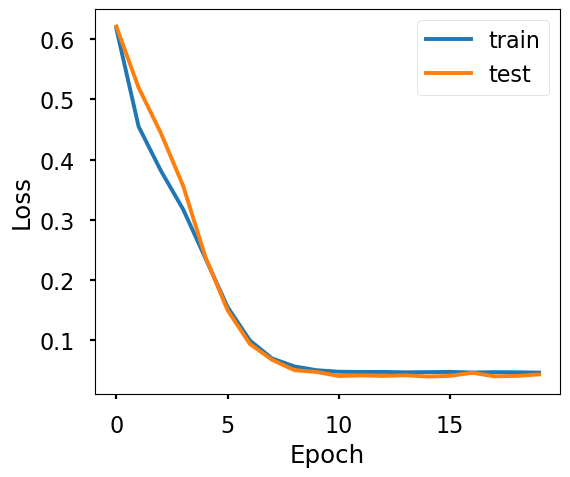

In [12]:
""" Train the model the better, but more complicated way. """

# set hyperparameters
learning_rate = 0.01
num_epochs = 20
batch_size = 32
training_fraction = 0.8
test_fraction = 0.1
n_hidden = 2

# define the model
# set torch's random seed for reproducibility
torch.manual_seed(5984)
model_2 = Net(n_hidden = n_hidden)

# set the optimizer
optim = torch.optim.AdamW(model_2.parameters(), lr = learning_rate)

# set the loss function
loss_fn = nn.MSELoss()

# set the sizes of the training, test, and validation sets
n_train = int(training_fraction*len(x))
n_test = int(test_fraction*len(x))
n_val = len(x) - n_train - n_test

# create a random set of indices
np.random.seed(5984)
i_random = np.random.choice(len(x), len(x), replace = False)

# use the random indices to choose indices for the training, test, and validation sets
i_train = i_random[:n_train]
i_test = i_random[n_train:n_train+n_test]
i_val = i_random[n_train+n_test:]

# use the random indices to randomly split the data
x_train = xt[i_train]
x_test = xt[i_test]
x_val = xt[i_val]

# define data loaders for the training, test, and validation sets
from torch.utils.data import TensorDataset, DataLoader
train_ds = TensorDataset(x_train, yt[i_train])
test_ds = TensorDataset(x_test, yt[i_test])
val_ds = TensorDataset(x_val, yt[i_val])
train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle = True)
test_dl = DataLoader(test_ds, batch_size = batch_size, shuffle = False)
val_dl = DataLoader(val_ds, batch_size = batch_size, shuffle = False)

# define the training loop function
def train_loop(dataloader, model, loss_fn, optim):

    # set the model to training mode
    model.train()

    batch_loss = []

    # loop over the batches
    for batch, (xx, yy) in enumerate(dataloader):
        # zero the gradients
        optim.zero_grad()

        # calculate the gradients
        pred = model(xx)
        loss = loss_fn(pred, yy)
        loss.backward()

        # update the parameters
        optim.step()

        # save the loss
        batch_loss.append(loss.item())
    
    # return the average loss across batches
    return np.mean(batch_loss)
    

# define a test loop function
def test_loop(dataloader, model, loss_fn):
    
    # set the model to evaluation mode
    model.eval()

    # initialize the loss
    loss = 0

    # no need to calculate gradients when testing
    with torch.no_grad():
        # loop over the batches
        for xx, yy in dataloader:

            # calculate the prediction
            pred = model(xx)

            # calculate the loss
            loss += loss_fn(pred, yy).item()

    # return the average loss across batches
    return loss/len(dataloader)


# train the model
train_loss = []
test_loss = []
for epoch in range(num_epochs):
    # calculate the training loss
    train_loss_tmp = train_loop(train_dl, model_2, loss_fn, optim)
    train_loss.append(train_loss_tmp)
    # calculate the test loss
    test_loss_tmp = test_loop(test_dl, model_2, loss_fn)
    test_loss.append(test_loss_tmp)

# plot the training and test loss
fig, ax = plt.subplots(figsize = (6,5))
ax.plot(train_loss, label="train")
ax.plot(test_loss, label="test")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()
plt.show()



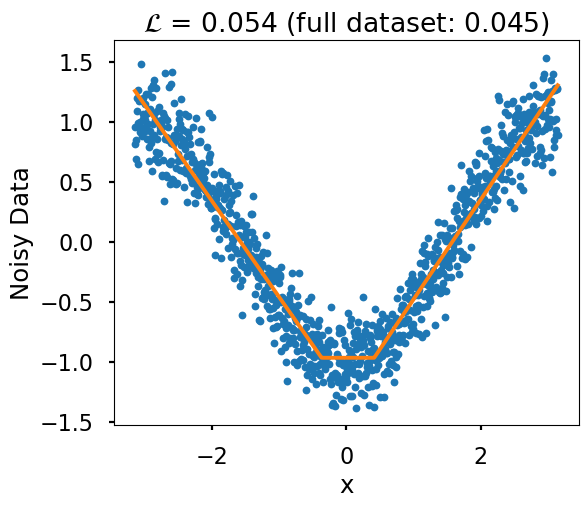

In [13]:
""" Plot the prediction """
# calculate the prediction
pred = model_2(xt)

# calculate the loss on the validation set
loss = test_loop(val_dl, model_2, loss_fn)

# calculate the loss on the whole dataset
full_loss = loss_fn(pred, yt)


# plot the noisy data and fit
fig, ax = plt.subplots(figsize = (6,5))
ax.plot(x, noisy_data, '.', label="data")
ax.plot(x, pred.detach().numpy(), label="fit")
ax.set_xlabel("x")
ax.set_ylabel("Noisy Data")
ax.set_title("$\mathcal{L}$ = " +  f"{loss:.3f} (full dataset: {full_loss:.3f})")
plt.show()